Nous allons débuter l'analyse de données concernant OpenFoodFacts dans l'objectif de proposer une idée d'application au service de la santé publique.

Pour commencer, nous allons importer les librairies scientifiques qui nous permettrons de travailler de manière efficace.

In [1]:
import pandas as pd 
import numpy as np 
import re 
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") # Nous coupons certains warning

Maintenant que nous avons à disposition l'ensemble des librairies utile au bon déroulement de cette analyse de données, nous allons charger nos données et démarrer le nettoyage de celle-ci.

Dans le fichier des keywords, il nous est précisé que les champs sont séparés par une tabulation. Nous devrons donc le préciser à pandas lors du chargement des données.

In [2]:
data = pd.read_csv("data/fr.openfoodfacts.org.products.csv", "\t")

Affichons maintenant le début des données pour en voir l'aperçu avant de démarrer le nettoyage.

In [3]:
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-fr.openfoodfacts.org/produit/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-fr.openfoodfacts.org/produit/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1624390765,2021-06-22T19:39:25Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


La colonne (product name) éveille notre attention, en effet, cette colonne contient les noms de chaque produit.


Voyons, s'il y a des valeurs dupliquées (on choisit "Peanuits" pour les besoins du test) :

In [4]:
peanuts = data.loc[data['product_name']=='Peanuts']

print(peanuts.head())

print(f"Nombre de lignes comprenant Peanuts : {len(peanuts)}")

                code                                                url  \
62     0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
295    0000000045599  http://world-fr.openfoodfacts.org/produit/0000...   
3979   0009166888088  http://world-fr.openfoodfacts.org/produit/0009...   
5333          106313  http://world-fr.openfoodfacts.org/produit/0010...   
10616    11110872098  http://world-fr.openfoodfacts.org/produit/0011...   

               creator   created_t      created_datetime  last_modified_t  \
62     usda-ndb-import  1489069957  2017-03-09T14:32:37Z       1489069957   
295    usda-ndb-import  1489050423  2017-03-09T09:07:03Z       1489050423   
3979           kiliweb  1628486431  2021-08-09T05:20:31Z       1628486432   
5333   usda-ndb-import  1489061323  2017-03-09T12:08:43Z       1587577372   
10616  usda-ndb-import  1489073121  2017-03-09T15:25:21Z       1587586045   

      last_modified_datetime product_name abbreviated_product_name  \
62      2017-03-

En observant la sortie, nous nous rendons compte qu'il y a plusieurs entrées pour Peanuts. Cela s'explique par le fait que les personnes peuvent ajouter des données ou mettre à jour des données manquantes.

Nous allons supprimer les duplicata en gardant le dernier en date pour garder la dernière mise à jour.

In [5]:
data_clean = data.drop_duplicates(subset="product_name", keep='last')

print(f"Il y a un total de {len(data) - len(data_clean)} lignes dupliquées.")    

data = data_clean 

Il y a un total de 766838 lignes dupliquées.


Nous voyons désormais qu'un total assez important de lignes étaient dupliqué. Vérifions si les changements ont bien fonctionné.

In [6]:
peanuts = data.loc[data['product_name']=='Peanuts']
print(f"Nombre de lignes comprenant Peanuts : {len(peanuts)}")

Nombre de lignes comprenant Peanuts : 1


Nous voyons qu'il ne reste effectivement plus qu'une ligne dans Peanuts.

Désormais, nous allons supprimer les valeurs manquantes et faire de l'imputation après avoir nettoyé les valeurs aberrantes pour éviter les risques d'erreurs.

In [7]:
cd = data[data.columns[data.isna().sum() / data.shape[0] <= 0.8]].copy()
cd.dropna(how='all',inplace=True) 
cd.drop_duplicates(keep="first",inplace=True) 
cd = cd[cd["product_name"].notna()] 
data = cd.copy()

def clean_string(value):
    value = re.sub(r'&quot;','\"',value)
    value = re.sub(r'&deg;','°',value)
    value = re.sub(r'&gt;','>',value)
    value = re.sub(r'&lt;','<',value)
    value = re.sub(r'^\s+|\s+$','',value)
    value = re.sub(r'^[,.\';:!&+]','',value)
    value = re.sub(r'[,\';:&]$','',value)
    value = re.sub(r'^\s+|\s+$','',value)
    return value.lower()

Maintenant, on a un dataset assez simplement nettoyé. Il faut désormais faire un nettoyage plus en profondeur au niveau des valeurs aberrante ou manquantes sur les valeurs quantitatives.

On prendra exclusivement les données française pour l'application choisis

In [8]:
france = ["France","france","française","FRANCE","fr","French","french","FRENCH", "Polynesie française", "Guadeloupe", "guadeloupe", "francia", "Francia"]

def is_only_france_countrie(row,split,prefix_size=3)->bool:
    if len(row.split(split))!=1:
        return False
    if row in france:
        return True
    else:
        if row[prefix_size:] in france:
            return True
        else:
            return False

value_countries_only_fr = [p for p in list(data["countries"].value_counts().index) if is_only_france_countrie(p,", ")]  
data_france = data.loc[data["countries"].isin(value_countries_only_fr)]

quantitative = [col for col in data.columns if col.endswith("_100g")]

selected_columns = quantitative.copy()
selected_columns.append("product_name")
selected_columns.append("pnns_groups_1")
selected_columns.append("pnns_groups_2")
selected_columns.append("nutriscore_grade")

data = data_france[selected_columns] 

data = data[data['pnns_groups_1'].notna()]
data = data[data['pnns_groups_2'].notna()]
data = data[data["nutriscore_grade"].notna()]

print(len(data))
data = data.dropna(how="all",subset=quantitative) 
print(len(data))

149023
149023


Nous venons de nous occuper du nettoyage simple et sans risque des valeurs quantitatives, il faut maintenant continuer en voyant la distribution des Non-nan

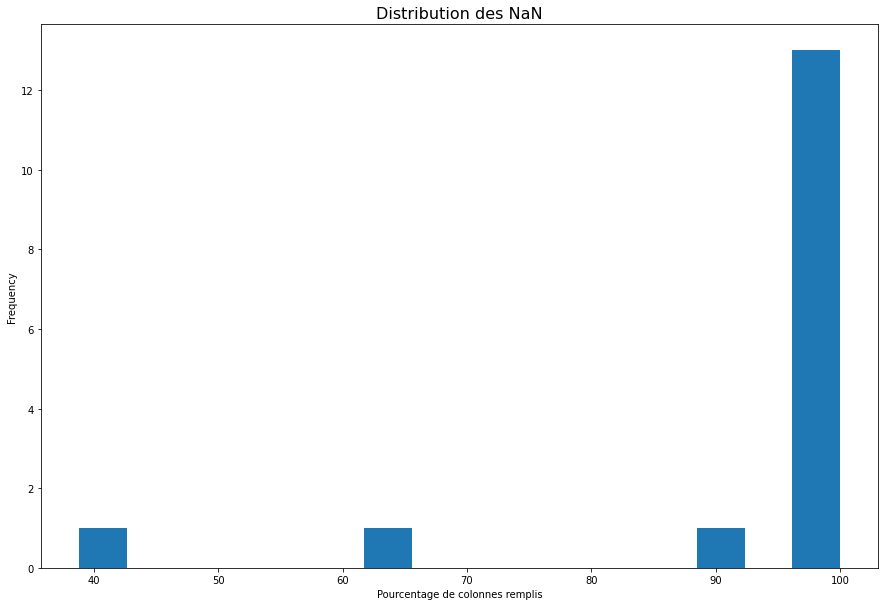

{'nutrition-score-fr_100g': '100.0%', 'product_name': '100.0%', 'pnns_groups_1': '100.0%', 'pnns_groups_2': '100.0%', 'nutriscore_grade': '100.0%', 'salt_100g': '99.885%', 'sodium_100g': '99.885%', 'energy_100g': '99.87%', 'saturated-fat_100g': '99.869%', 'sugars_100g': '99.868%', 'proteins_100g': '99.868%', 'fat_100g': '99.867%', 'carbohydrates_100g': '99.819%', 'energy-kcal_100g': '90.954%', 'fruits-vegetables-nuts-estimate-from-ingredients_100g': '62.856%', 'fiber_100g': '38.797%'}


In [9]:
notna = ((data.notna().sum() / data.shape[0]) * 100).sort_values(ascending=False)
notna.plot(kind="hist", figsize=(15,10), bins=notna.shape[0])
plt.title("Distribution des NaN", fontsize=16)
plt.xlabel("Pourcentage de colonnes remplis")
plt.show()

notna = ((data.notna().sum() / data.shape[0]) * 100).round(3).sort_values(ascending=False)
res = { notna.index[k]:str(v) + "%" for k,v in enumerate(notna) }
print(res)   

Nous remarquons que le notebook est plutôt bien rempli

Néanmoins, ils restent encore des NaN dans les variables quantitatives, nous allons essayer de mettre en place un KNNImputer mais avant, nous devons nous assurer qu'il n'existe plus de valeurs abbérante dans notre dataset pour les valeurs quantitative

In [10]:
data[quantitative].describe()

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,1.355420e+05,1.488300e+05,148825.000000,148828.000000,148754.000000,148827.000000,57816.000000,148827.000000,148852.000000,148852.000000,93670.000000,149023.000000
mean,2.875573e+02,1.202428e+03,14.963078,5.779047,26.648084,12.963338,2.685719,9.101933,1.131344,0.452869,13.294675,9.540011
std,3.698385e+03,2.077531e+04,77.207695,9.878213,498.442914,72.350110,4.148140,189.400558,36.883104,14.753800,45.065664,8.756459
min,0.000000e+00,0.000000e+00,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,1.210000e+02,4.980000e+02,1.600000,0.400000,2.500000,0.700000,0.300000,2.000000,0.090000,0.036000,0.000000,2.000000
50%,2.520000e+02,1.042000e+03,9.000000,2.400000,13.000000,3.300000,1.600000,6.400000,0.600000,0.240000,0.000000,10.000000
75%,3.990000e+02,1.657000e+03,22.800000,8.400000,49.000000,18.000000,3.420000,12.500000,1.300000,0.520000,11.731250,16.000000
max,1.360000e+06,8.010000e+06,29000.000000,2000.000000,192000.000000,27000.000000,96.000000,73000.000000,14000.000000,5600.000000,7314.000000,40.000000


Les valeurs min semblent bonne mais les valeurs max sont abbérantes pour energy-kcal_100g, energy_100g, carbohydrates_100g, calcium_100g, fruits-vegetables-nuts-estimate-from-ingredients_100g

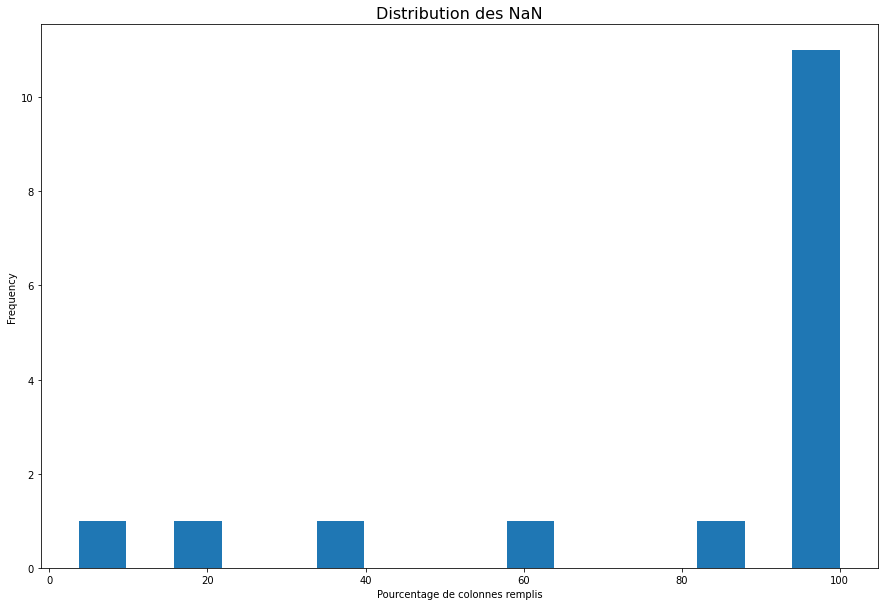

{'product_name': '100.0%', 'pnns_groups_1': '100.0%', 'pnns_groups_2': '100.0%', 'nutriscore_grade': '100.0%', 'sodium_100g': '99.884%', 'salt_100g': '99.883%', 'proteins_100g': '99.865%', 'fat_100g': '99.864%', 'saturated-fat_100g': '99.864%', 'sugars_100g': '99.864%', 'carbohydrates_100g': '99.814%', 'nutrition-score-fr_100g': '86.481%', 'fruits-vegetables-nuts-estimate-from-ingredients_100g': '63.769%', 'fiber_100g': '38.934%', 'energy-kcal_100g': '17.924%', 'energy_100g': '3.727%'}


,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,24328.000000,5059.000000,135541.000000,135541.000000,135473.000000,135542.000000,52844.000000,135543.000000,135567.000000,135568.000000,86551.000000,117377.000000
mean,50.312816,42.030514,15.099506,5.944545,25.251346,12.736726,2.593154,8.559705,0.975269,0.390882,12.287108,11.556336
std,28.212493,37.175629,18.043361,8.498436,26.339788,18.398053,3.823318,8.051277,1.844424,0.765018,24.850589,7.705107
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,4.000000,1.700000,0.400000,2.400000,0.700000,0.300000,2.200000,0.100000,0.040000,0.000000,4.000000
50%,48.000000,42.000000,9.300000,2.500000,13.000000,3.300000,1.600000,6.500000,0.600000,0.240000,0.000000,12.000000
75%,73.000000,79.000000,23.000000,8.800000,49.000000,18.000000,3.400000,12.600000,1.300000,0.520000,11.111111,17.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,96.000000,100.000000,100.000000,56.000000,100.000000,40.000000


In [11]:
for q in quantitative:
  data[q].values[data[q].values > 100] = np.nan
  data[q].values[data[q].values < 0] = np.nan
  
data.drop(index=data[data['pnns_groups_1'] == 'unknown'].index, inplace=True)
data.drop(index=data[data['pnns_groups_2'] == 'unknown'].index, inplace=True)
data.drop(index=data[data['nutriscore_grade'] == 'unknown'].index, inplace=True)

notna = ((data.notna().sum() / data.shape[0]) * 100).sort_values(ascending=False)
notna.plot(kind="hist", figsize=(15,10), bins=notna.shape[0])
plt.title("Distribution des NaN", fontsize=16)
plt.xlabel("Pourcentage de colonnes remplis")
plt.show()

notna = ((data.notna().sum() / data.shape[0]) * 100).round(3).sort_values(ascending=False)
res = { notna.index[k]:str(v) + "%" for k,v in enumerate(notna) }
print(res)   
data[quantitative].describe()

Nous voyons que les valeurs sont désormais plus réaliste. Maintenant que les valeurs aberrantes ont été traitées, nous allons nous occuper de mettre en place le KNNImputer sur les valeurs quantitatives


In [12]:
from sklearn.impute import KNNImputer
 
temp_data = data.copy()
imputer = KNNImputer(n_neighbors=5)
  
temp_data[quantitative] = imputer.fit_transform(temp_data[quantitative])

pd.concat([temp_data,data["product_name"]],axis=1,join="inner").to_csv("data/data_imputer.csv", sep="\t", index=False)

Verifions maintenant le taux de remplissage :

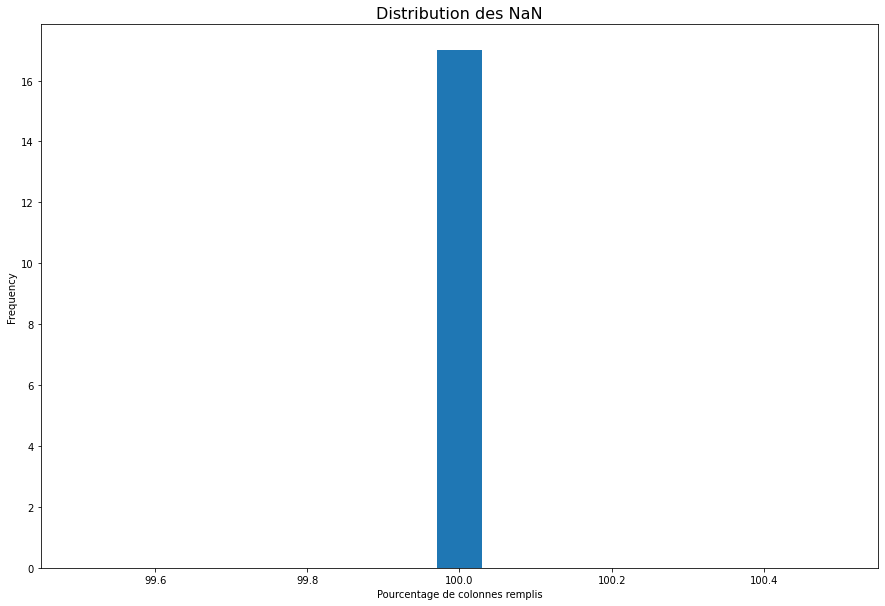

{'energy-kcal_100g': '100.0%', 'sodium_100g': '100.0%', 'nutriscore_grade': '100.0%', 'pnns_groups_2': '100.0%', 'pnns_groups_1': '100.0%', 'product_name': '100.0%', 'nutrition-score-fr_100g': '100.0%', 'fruits-vegetables-nuts-estimate-from-ingredients_100g': '100.0%', 'salt_100g': '100.0%', 'energy_100g': '100.0%', 'proteins_100g': '100.0%', 'fiber_100g': '100.0%', 'sugars_100g': '100.0%', 'carbohydrates_100g': '100.0%', 'saturated-fat_100g': '100.0%', 'fat_100g': '100.0%', 'product_name.1': '100.0%'}


,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g,product_name,pnns_groups_1,pnns_groups_2,nutriscore_grade,product_name.1
0,60.4,33.4,8.2,2.2,29.0,22.0,0.0,5.1,4.600,1.8400,0.0,18.0,moutarde au moût de raisin,Fat and sauces,Dressings and sauces,d,moutarde au moût de raisin
1,25.6,0.0,12.7,1.0,3.9,1.0,3.0,1.9,0.270,0.1080,15.7,1.0,Salade de macedoine de légumes,Composite foods,One-dish meals,b,Salade de macedoine de légumes
2,18.8,6.6,13.0,4.0,3.0,0.9,0.4,17.0,1.100,0.4400,0.0,4.0,cuisse de poulet direct au four curry,Fish Meat Eggs,Meat,c,cuisse de poulet direct au four curry
3,27.0,1.6,2.2,0.5,25.2,0.6,1.6,9.5,0.358,0.1432,0.0,0.0,BAguette bressan,Cereals and potatoes,Bread,a,BAguette bressan
4,23.6,0.0,29.0,11.0,0.0,0.0,0.3,16.0,1.600,0.6400,0.0,21.0,Rillettes de sanglier au Chouchen,Salty snacks,Salty and fatty products,e,Rillettes de sanglier au Chouchen


In [13]:
data = pd.read_csv("data/data_imputer.csv", "\t")

notna = ((data.notna().sum() / data.shape[0]) * 100).sort_values(ascending=False)
notna.plot(kind="hist", figsize=(15,10), bins=notna.shape[0])
plt.title("Distribution des NaN", fontsize=16)
plt.xlabel("Pourcentage de colonnes remplis")
plt.show()

notna = ((data.notna().sum() / data.shape[0]) * 100).round(3).sort_values(ascending=False)
res = { notna.index[k]:str(v) + "%" for k,v in enumerate(notna) } 
print(res)   

data.head()